In [932]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from glob import glob
from sklearn import linear_model

import os
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind') 

# Warnings control
import warnings 
warnings.filterwarnings('ignore')

In [933]:
def get_stock_delta_cols(df):
    df["Delta"] = df["Close"] - df["Close"].shift(1)
    df["Delta %"] = df["Delta"] / df["Close"]
    return df


In [934]:
def get_testing_correlations():
    base = pd.DataFrame()

    for f in glob("stock-price-predictions/price/*"):
        company = f.split("/")[-1][:-4]

        data_path_stock = Path(f'stock-price-predictions/price/{company}.csv')
        df = pd.read_csv(data_path_stock, header=0)

        df = df[["Date", "Close"]].rename(columns={"Close":company})

        if base.empty:
            base = df
        else:
            base = base.merge(
                right=df, 
                how="left",
                on="Date"
            )

    base.set_index('Date', inplace=True)
    base.index = pd.to_datetime(base.index)
    base = base.loc[base.index < '01-01-2016'] #restricts to train domain

    return base.corr(numeric_only=False)

In [935]:
correlations_df = get_testing_correlations()

correlations_df

,XOM,MSFT,CELG,MMM,C,BCH,CHL,MO,AEP,BA,...,RDS-B,EXC,PG,PCLN,SLB,GD,PCG,WMT,SNY,D
XOM,1.000000,-0.190075,-0.363670,-0.087806,-0.170885,0.394913,-0.474108,-0.472340,-0.163960,-0.103567,...,0.931245,0.303763,0.375033,-0.026506,0.671153,-0.261683,-0.410485,0.544238,0.381341,0.030343
MSFT,-0.190075,1.000000,0.878255,0.895167,0.729967,-0.866535,0.452204,0.889700,0.848522,0.836716,...,-0.314167,0.068309,0.487353,0.839533,0.348328,0.936744,0.751564,-0.103213,0.037858,0.825519
CELG,-0.363670,0.878255,1.000000,0.936550,0.823256,-0.839450,0.619676,0.927439,0.866920,0.892143,...,-0.451101,0.043373,0.510561,0.809457,0.238922,0.954460,0.821465,0.020014,0.091065,0.858904
MMM,-0.087806,0.895167,0.936550,1.000000,0.789112,-0.797346,0.514899,0.858215,0.888530,0.933980,...,-0.208316,0.152981,0.656540,0.853873,0.452553,0.947541,0.774893,0.182016,0.138254,0.928977
C,-0.170885,0.729967,0.823256,0.789112,1.000000,-0.558425,0.372536,0.655723,0.613567,0.829349,...,-0.306855,-0.105248,0.617849,0.759793,0.327142,0.743924,0.544933,0.073142,0.410608,0.716639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GD,-0.261683,0.936744,0.954460,0.947541,0.743924,-0.896845,0.562651,0.926854,0.900211,0.869605,...,-0.334607,0.143594,0.470351,0.840540,0.340681,1.000000,0.811519,-0.020805,0.052905,0.883964
PCG,-0.410485,0.751564,0.821465,0.774893,0.544933,-0.772472,0.673439,0.900142,0.906379,0.619861,...,-0.500779,0.335391,0.398036,0.486036,-0.022187,0.811519,1.000000,0.056589,-0.120374,0.699085
WMT,0.544238,-0.103213,0.020014,0.182016,0.073142,0.171154,0.069140,-0.151676,0.158220,0.095940,...,0.512203,0.561510,0.664136,-0.070386,0.360615,-0.020805,0.056589,1.000000,0.253073,0.265298
SNY,0.381341,0.037858,0.091065,0.138254,0.410608,0.129545,-0.137088,-0.098448,0.031460,0.259400,...,0.405866,0.089570,0.322142,0.289465,0.540623,0.052905,-0.120374,0.253073,1.000000,0.243464


In [936]:
def get_new_model():
    return linear_model.BayesianRidge(
        max_iter=10000, 
        tol=10, 
        alpha_1=1e-06, 
        alpha_2=1e-06, 
        lambda_1=10, 
        lambda_2=10, 
        alpha_init=100, 
        lambda_init=0.01, 
        compute_score=False, 
        fit_intercept=True, 
        copy_X=True, 
        verbose=False
    )

chosen_company = "AAPL"
needed_price_vars = ['RSI_Mean', 'Previous Day Percentage Change', 'BB Signal', 'BB Z-Score', 'RSI', 'RSI Signal', 'RSI Z-Score', 'Combined Signal']

In [937]:
def train_model(x_data, y_data):
    model = get_new_model()
    index_split = round(len(x_data) * 0.75)

    x_train = x_data[:index_split]
    y_train = y_data[:index_split]

    x_test = x_data[index_split:]
    y_test = y_data[index_split:]

    model.fit(
        x_train,
        y_train
    )

    score = model.score(x_test, y_test)
    predictions = model.predict(x_test)
    return (score, predictions, model)

In [938]:
def get_price_indicators(df):
    df['Percentage Change'] = df['Close'].pct_change()
    df['Previous Day Percentage Change'] = df['Percentage Change'].shift(1)
    df['20SMA'] = df['Close'].rolling(window=20).mean()
    df['50SMA'] = df['Close'].rolling(window=50).mean()
    df['Std Dev'] = df['Close'].rolling(window=20).std()

    # BB
    df['UpperB'] = df['20SMA'] + 2 * df['Std Dev']
    df['LowerB'] = df['20SMA'] - 2 * df['Std Dev']

    df['BB Signal'] = 0
    df['BB Signal'] = np.where(df['Close'] < df['LowerB'], 1, df['BB Signal'])
    df['BB Signal'] = np.where(df['Close'] > df['UpperB'], -1, df['BB Signal'])

    df['BB Z-Score'] = (df['Close'] - df['20SMA']) / df['Std Dev']

    # RSI
    rsi_period = 14
    rsi_buy = 70
    rsi_sell = 30

    RS = df['Close'].diff()
    gain = (RS.where(RS > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-RS.where(RS < 0, 0)).rolling(window=rsi_period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    df['RSI'] = rsi
    df['RSI_Mean'] = df['RSI'].rolling(window=14).mean()  # 14-period rolling mean of RSI
    df['RSI_Std'] = df['RSI'].rolling(window=14).std()    # 14-period rolling standard deviation of RSI

    df['RSI Signal'] = 0  # 0: no signal, 1: buy, -1: sell
    df.loc[(df['20SMA'] > df['50SMA']) & (rsi < rsi_buy), 'RSI Signal'] = 1
    df.loc[(df['20SMA'] < df['50SMA']) & (rsi > rsi_sell), 'RSI Signal'] = -1

    df['RSI Z-Score'] = (df['RSI'] - df['RSI_Mean']) / df['RSI_Std']  # Z-Score of RSI

    # Combined
    df['Combined Signal'] = 0

    df.loc[(df['BB Signal'] == 1) & (df['RSI Signal'] == 1), 'Combined Signal'] = 1
    df.loc[(df['BB Signal'] == -1) & (df['RSI Signal'] == -1), 'Combined Signal'] = -1

    return df

In [939]:
def get_sentiment_models():
    models = []
    scores = []

    for f in glob("stock-price-predictions/price/*"):
        company = f.split("/")[-1][:-4]

        # Sentiment
        try:
            data_path_sentiment = Path(f'stock-price-predictions/tweet/{company}/daily_tweet_sentiment.csv')
            sentiment_df = pd.read_csv(data_path_sentiment, header=0)
        except:
            continue # reject company for modelling

        sentiment_df.set_index('day', inplace=True)
        sentiment_df.index = pd.to_datetime(sentiment_df.index)

        sentiment_df.shift(1)

        # Pricing
        data_path_stock = Path(f'stock-price-predictions/price/{company}.csv')
        df = pd.read_csv(data_path_stock, header=0)
        df = df[["Date", "Close"]]
        
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.loc[df.index < '01-01-2016']

        df = get_price_indicators(df)

        # Merge
        df = df.merge(
            right=sentiment_df, 
            how="left",
            left_index=True,
            right_index=True
        )

        x_data = df[needed_price_vars + ['sentiment_number']].fillna(value=0)
        y_data = df['Percentage Change'].fillna(value=0)

        score, predictions, model = train_model(x_data, y_data)

        models.append((company, model, x_data, y_data))
        scores.append(score)
    
    return models, scores

In [940]:
def get_non_sentiment_models():
    models = []
    scores = []

    for f in glob("stock-price-predictions/price/*"):
        company = f.split("/")[-1][:-4]

        # Sentiment
        try:
            data_path_sentiment = Path(f'stock-price-predictions/tweet/{company}/daily_tweet_sentiment.csv')
            sentiment_df = pd.read_csv(data_path_sentiment, header=0)
        except:
            continue # reject company for modelling

        # Pricing
        data_path_stock = Path(f'stock-price-predictions/price/{company}.csv')
        df = pd.read_csv(data_path_stock, header=0)
        df = df[["Date", "Close"]]
        
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.loc[df.index < '01-01-2016']

        df = get_price_indicators(df)
        
        x_data = df[needed_price_vars].fillna(value=0)
        y_data = df['Percentage Change'].fillna(value=0)

        score, predictions, model = train_model(x_data, y_data)

        models.append((company, model, x_data, y_data))
        scores.append(score)
    
    return models, scores

In [941]:
s_models, s_scores = get_sentiment_models()
n_models, n_scores = get_non_sentiment_models()

In [942]:
# print difference w/ vs w/o
for i in range(len(s_scores)):
    print(f"{s_models[i][0]:<5}: {s_scores[i]:<24} | {n_scores[i]:<24} | {s_scores[i] - n_scores[i]}")

XOM  : 0.2206615629105122       | 0.22469063497394481      | -0.004029072063432615
MSFT : 0.3054767907493199       | 0.30039362011712345      | 0.005083170632196432
CELG : 0.2872770001597209       | 0.2884647172004552       | -0.0011877170407342819
MMM  : 0.3966071085959453       | 0.397382264455444        | -0.0007751558594987218
C    : 0.34050933514157855      | 0.3393850824594785       | 0.0011242526821000354
BCH  : 0.29635825959538875      | 0.29639929042611823      | -4.103083072948266e-05
CHL  : 0.30441294439173183      | 0.30381788522146647      | 0.0005950591702653663
MO   : 0.371870475149799        | 0.37146294490561815      | 0.0004075302441808315
AEP  : 0.28215929687221564      | 0.29487892739588084      | -0.012719630523665204
BA   : 0.2787895029566956       | 0.27935427931459245      | -0.0005647763578968679
PTR  : 0.23282657471882495      | 0.23460678302033044      | -0.0017802083015054926
BRK-A: 0.3356745320957236       | 0.3387995109162677       | -0.0031249788205440776

In [943]:
s_chosen = None
n_chosen = None
for i in range(len(s_models)):
    if s_models[i][0] == chosen_company:
        s_chosen = s_models[i]
        n_chosen = n_models[i]
        s_models.pop(i)
        n_models.pop(i)
        break

In [944]:
s_pred_market_factors = pd.DataFrame()
n_pred_market_factors = pd.DataFrame()

s_preds = []
n_preds = []
for i in range(len(s_models)):
    s_preds.append((s_models[i][0], s_models[i][1].predict(s_models[i][2])))
    n_preds.append((n_models[i][0], n_models[i][1].predict(n_models[i][2])))

s_pred_market_factors.insert(0, "factor_sum", [0]*len(s_preds[0][1]))
for company, pred in s_preds:
    if len(s_pred_market_factors.axes[0]) != len(pred):
        continue

    s_pred_market_factors.insert(len(s_pred_market_factors.columns), company, pred)
    s_pred_market_factors["factor_sum"] += s_pred_market_factors[company] * correlations_df.loc[company, chosen_company]

n_pred_market_factors.insert(0, "factor_sum", [0]*len(n_preds[0][1]))
for company, pred in n_preds:
    if len(n_pred_market_factors.axes[0]) != len(pred):
        continue

    n_pred_market_factors.insert(len(n_pred_market_factors.columns), company, pred)
    n_pred_market_factors["factor_sum"] += n_pred_market_factors[company] * correlations_df.loc[company, chosen_company]

s_pred_market_factors = s_pred_market_factors["factor_sum"]
n_pred_market_factors = n_pred_market_factors["factor_sum"]

s_actual_market_factors = pd.DataFrame()
n_actual_market_factors = pd.DataFrame()

s_actual = []
n_actual = []
for i in range(len(s_models)):
    company = s_models[i][0]
    corr_coef = correlations_df.loc[company, chosen_company]

    s_actual.append((s_models[i][0], [x*corr_coef for x in s_models[i][3]]))
    n_actual.append((n_models[i][0], [x*corr_coef for x in n_models[i][3]]))

s_actual_market_factors.insert(0, "factor_sum", [0]*len(s_actual[0][1]))
for company, actual in s_actual:
    if len(s_actual_market_factors.axes[0]) != len(actual):
        continue

    s_actual_market_factors.insert(len(s_actual_market_factors.columns), company, actual)
    s_actual_market_factors["factor_sum"] += s_actual_market_factors[company]

n_actual_market_factors.insert(0, "factor_sum", [0]*len(n_actual[0][1]))
for company, actual in n_actual:
    if len(n_actual_market_factors.axes[0]) != len(actual):
        continue

    n_actual_market_factors.insert(len(n_actual_market_factors.columns), company, actual)
    n_actual_market_factors["factor_sum"] += n_actual_market_factors[company]

s_actual_market_factors = s_actual_market_factors["factor_sum"].shift(1).fillna(value=0)
n_actual_market_factors = n_actual_market_factors["factor_sum"].shift(1).fillna(value=0)

In [945]:
s_chosen[2].insert(len(s_chosen[2].columns), "Predicted Market Factor", 0)
s_chosen[2].insert(len(s_chosen[2].columns), "Previous Market Factor", 0)

i = 0
for date in s_chosen[2].index:
    s_chosen[2].loc[date, "Predicted Market Factor"] = s_pred_market_factors[i]
    s_chosen[2].loc[date, "Previous Market Factor"] = s_actual_market_factors[i]
    i += 1

n_chosen[2].insert(len(n_chosen[2].columns), "Predicted Market Factor", 0)
n_chosen[2].insert(len(n_chosen[2].columns), "Previous Market Factor", 0)

i = 0
for date in n_chosen[2].index:
    n_chosen[2].loc[date, "Predicted Market Factor"] = n_pred_market_factors[i]
    n_chosen[2].loc[date, "Previous Market Factor"] = n_actual_market_factors[i]
    i += 1

In [946]:
s_res = train_model(s_chosen[2], s_chosen[3])
n_res = train_model(n_chosen[2], n_chosen[3])

print(f"{chosen_company}: {s_res[0]:<19} | {n_res[0]:<19} | {s_res[0] - n_res[0]}")

AAPL: 0.3147765306892294  | 0.30676352598242096 | 0.008013004706808435


<Axes: title={'center': 'Sentiment vs Non-sentiment Prediction'}>

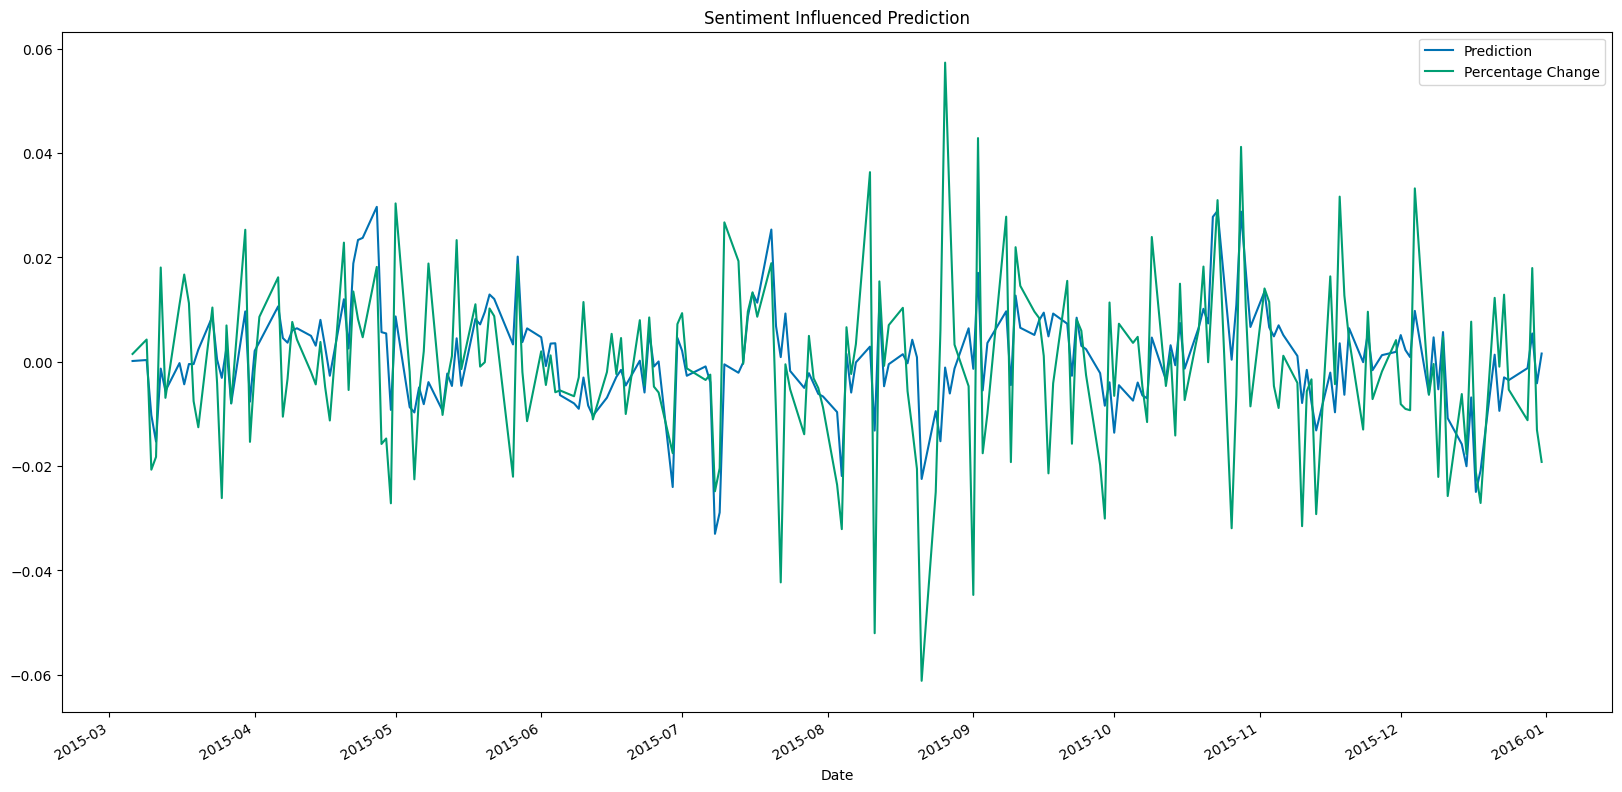

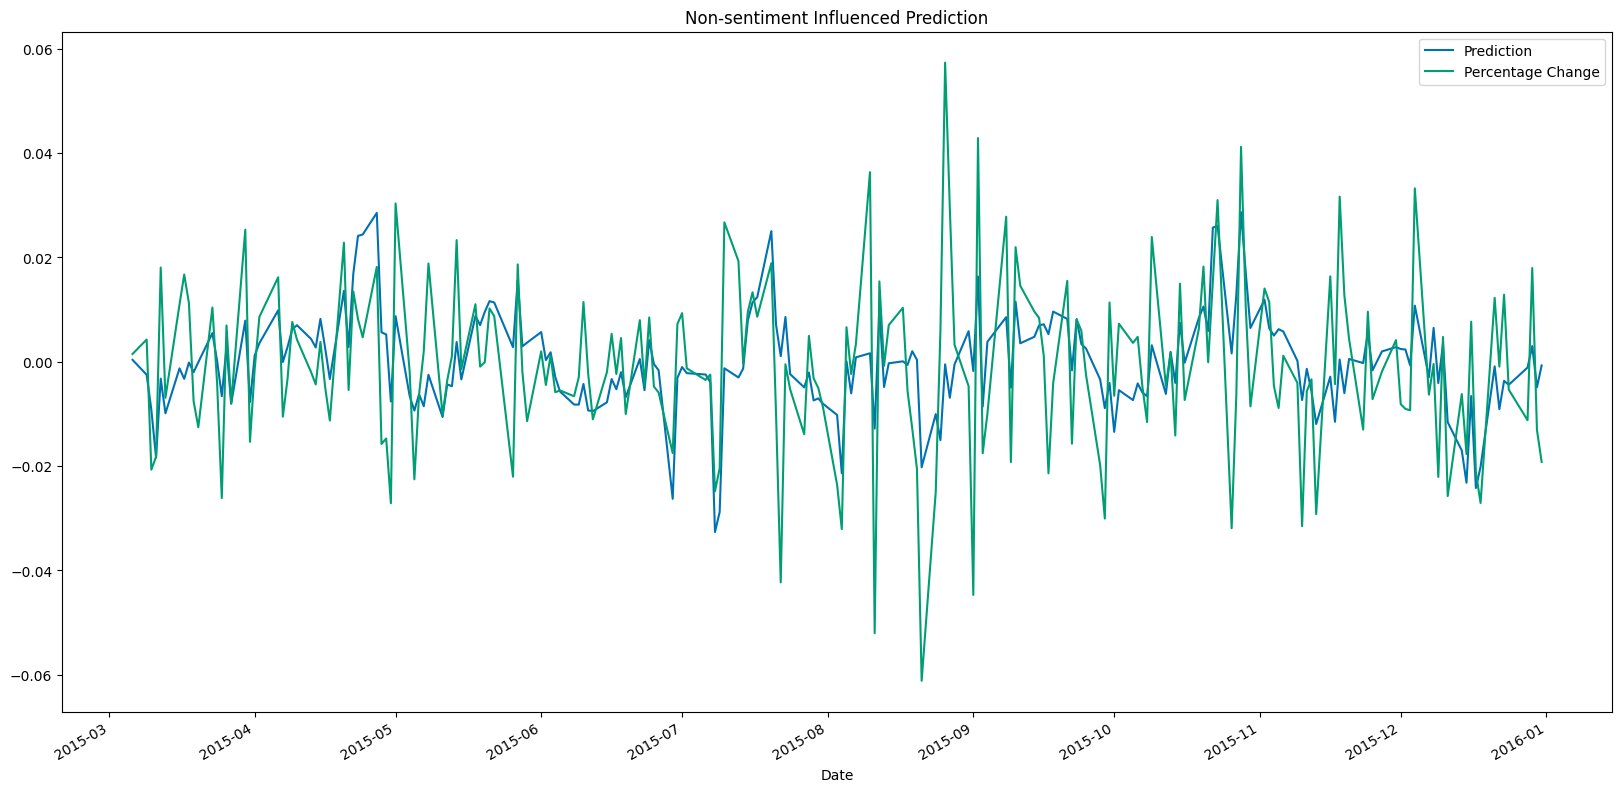

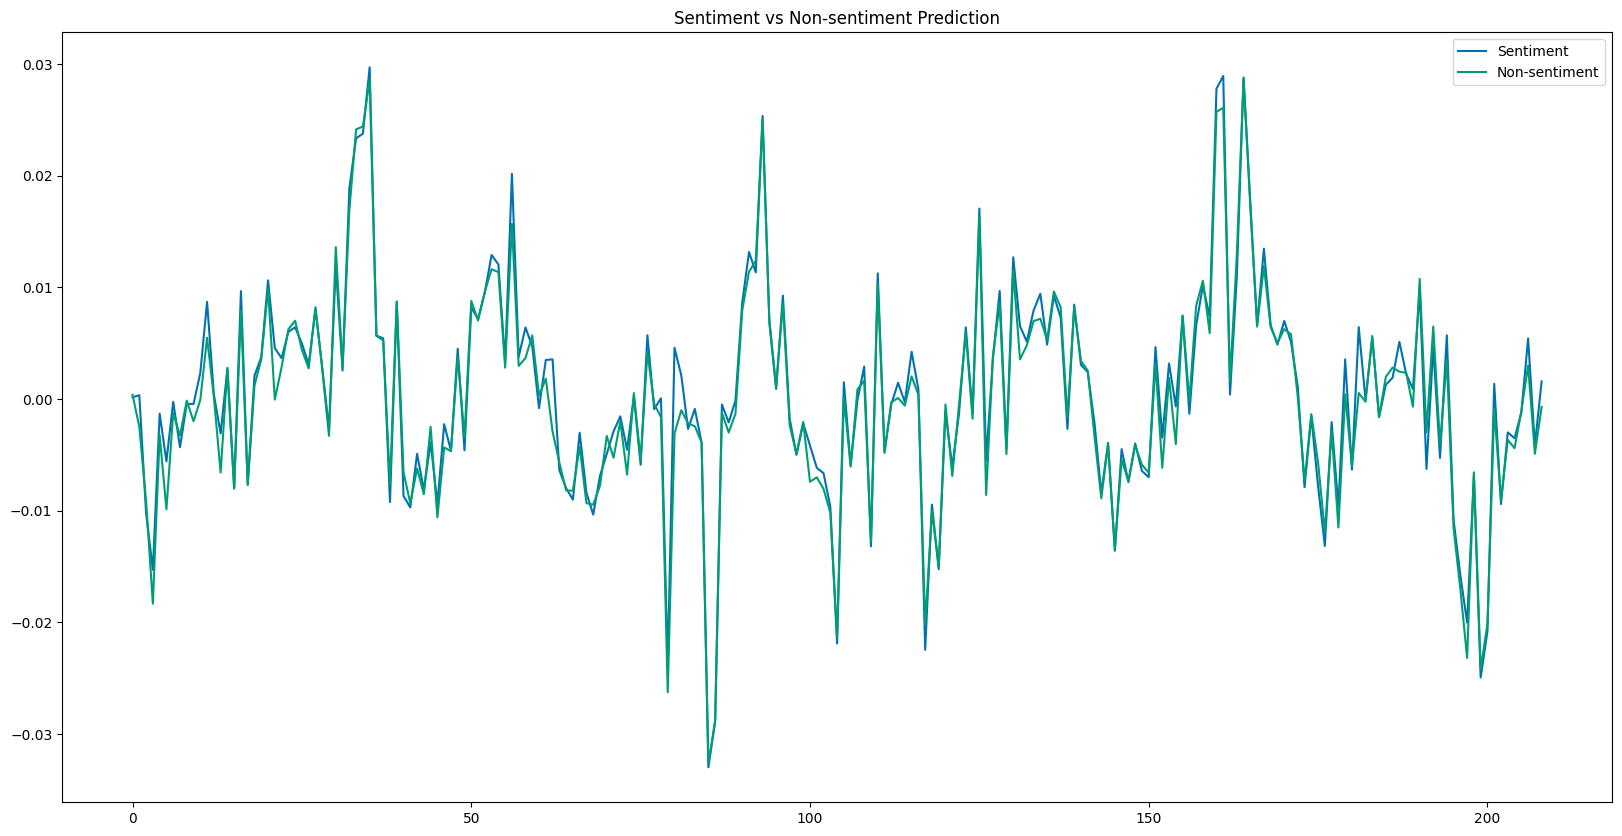

In [947]:
s_actual = s_chosen[3][-len(s_res[1]):]
s_prediction = s_res[1]
s_plot_data = pd.DataFrame(s_actual)
s_plot_data.insert(1, "Prediction", s_prediction)
s_plot_data.plot(y=["Prediction", "Percentage Change"], figsize=(20, 10), title="Sentiment Influenced Prediction")

n_actual = n_chosen[3][-len(n_res[1]):]
n_prediction = n_res[1]
n_plot_data = pd.DataFrame(n_actual)
n_plot_data.insert(1, "Prediction", n_prediction)
n_plot_data.plot(y=["Prediction", "Percentage Change"], figsize=(20, 10), title="Non-sentiment Influenced Prediction")

diff_plot_data = pd.DataFrame(data=s_prediction, columns=["Sentiment"])
diff_plot_data.insert(1, "Non-sentiment", n_prediction)
diff_plot_data.plot(y=["Sentiment", "Non-sentiment"], figsize=(20, 10), title="Sentiment vs Non-sentiment Prediction")

Agreement
 1    141
-1     68
Name: count, dtype: int64


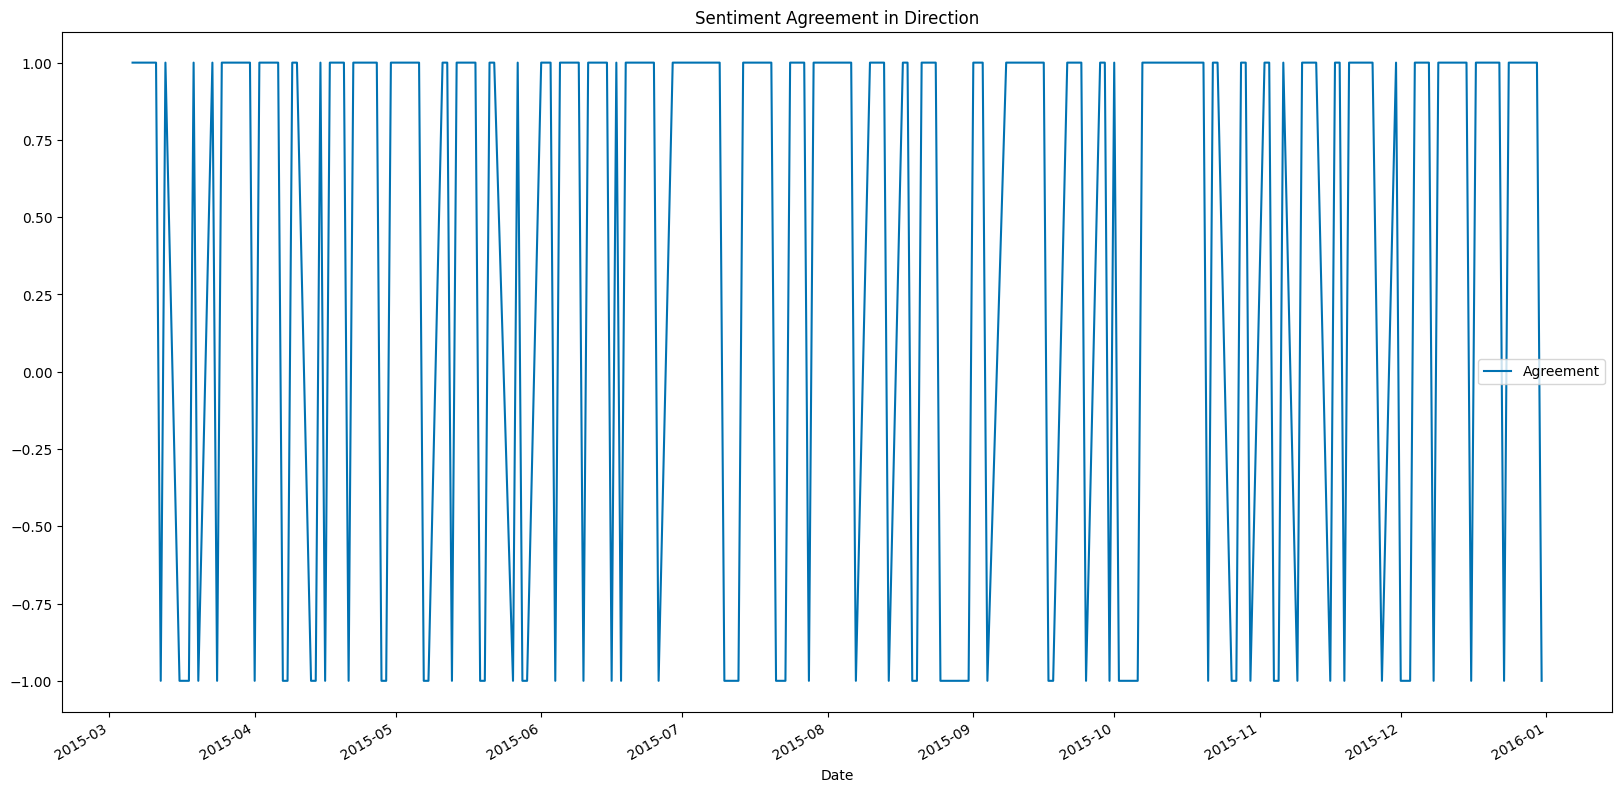

In [948]:
s_dir_df = pd.DataFrame(data=s_actual)
s_dir_df = s_dir_df.rename(columns={"Percentage Change":"Actual Dir"})
s_dir_df.insert(1, "Prediction Dir", s_prediction)

s_dir_df.loc[(s_dir_df["Actual Dir"] == 0), "Actual Dir"] = 0
s_dir_df.loc[(s_dir_df["Actual Dir"] > 0), "Actual Dir"] = 1
s_dir_df.loc[(s_dir_df["Actual Dir"] < 0), "Actual Dir"] = -1
s_dir_df.loc[(s_dir_df["Prediction Dir"] == 0), "Prediction Dir"] = 0
s_dir_df.loc[(s_dir_df["Prediction Dir"] > 0), "Prediction Dir"] = 1
s_dir_df.loc[(s_dir_df["Prediction Dir"] < 0), "Prediction Dir"] = -1

s_dir_df["Agreement"] = 0
s_dir_df.loc[(s_dir_df["Prediction Dir"] == s_dir_df["Actual Dir"]), "Agreement"] = 1
s_dir_df.loc[(s_dir_df["Prediction Dir"] * s_dir_df["Actual Dir"] == -1), "Agreement"] = -1 # opp

# s_dir_df.plot(y=["Actual Dir", "Prediction Dir"], figsize=(20, 10), title="Actual vs Sentiment Prediction Direction")
s_dir_df.plot(y=["Agreement"], figsize=(20, 10), title="Sentiment Agreement in Direction")

print(s_dir_df["Agreement"].value_counts())

Agreement
 1    143
-1     66
Name: count, dtype: int64


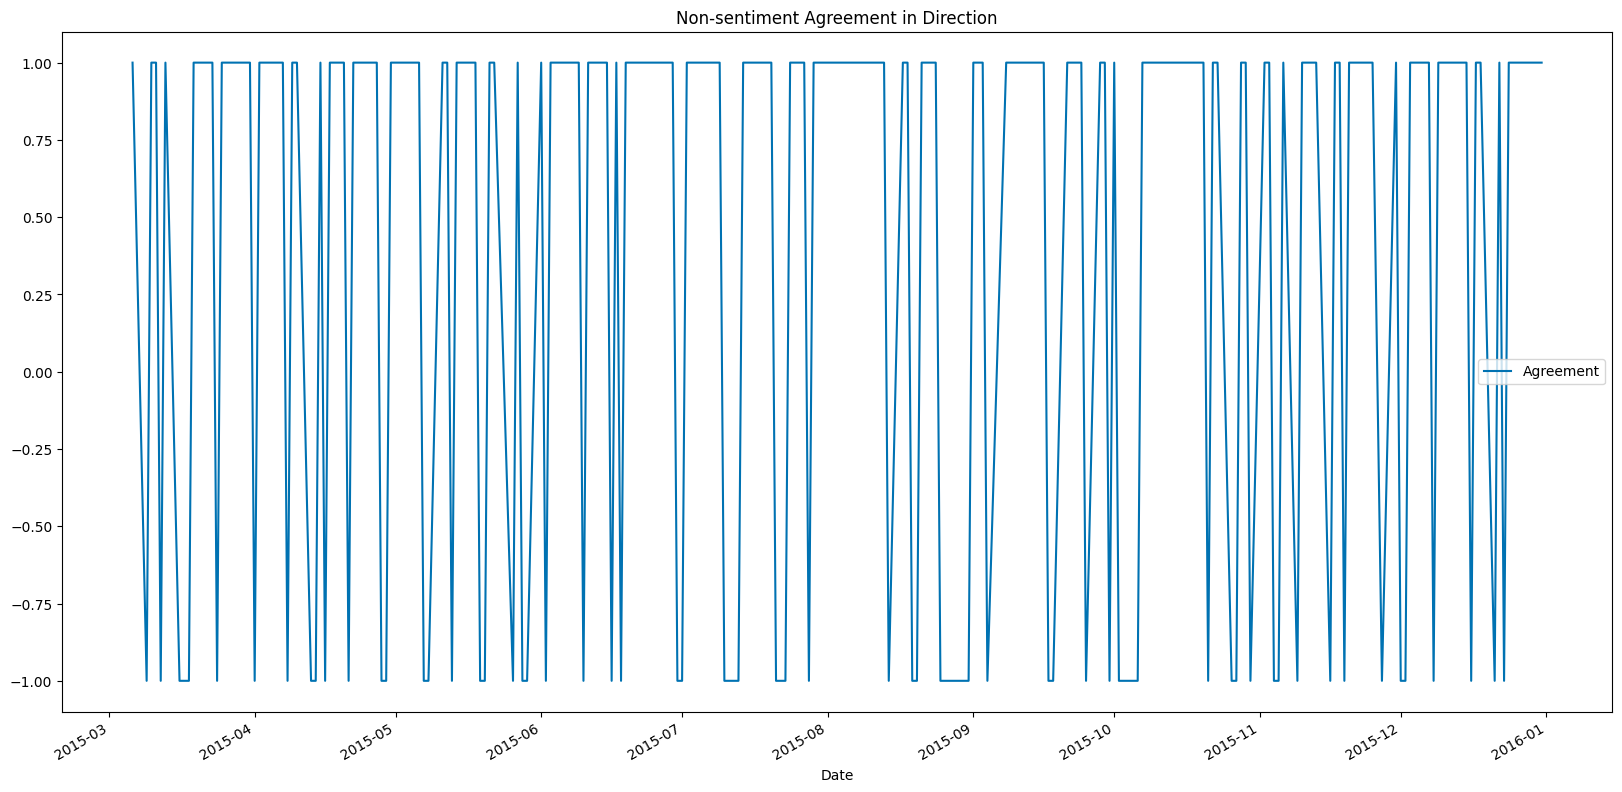

In [949]:
n_dir_df = pd.DataFrame(data=n_actual)
n_dir_df = n_dir_df.rename(columns={"Percentage Change":"Actual Dir"})
n_dir_df.insert(1, "Prediction Dir", n_prediction)

n_dir_df.loc[(n_dir_df["Actual Dir"] == 0), "Actual Dir"] = 0
n_dir_df.loc[(n_dir_df["Actual Dir"] > 0), "Actual Dir"] = 1
n_dir_df.loc[(n_dir_df["Actual Dir"] < 0), "Actual Dir"] = -1
n_dir_df.loc[(n_dir_df["Prediction Dir"] == 0), "Prediction Dir"] = 0
n_dir_df.loc[(n_dir_df["Prediction Dir"] > 0), "Prediction Dir"] = 1
n_dir_df.loc[(n_dir_df["Prediction Dir"] < 0), "Prediction Dir"] = -1

n_dir_df["Agreement"] = 0
n_dir_df.loc[(n_dir_df["Prediction Dir"] == n_dir_df["Actual Dir"]), "Agreement"] = 1
n_dir_df.loc[(n_dir_df["Prediction Dir"] * n_dir_df["Actual Dir"] == -1), "Agreement"] = -1 # opp

# n_dir_df.plot(y=["Actual Dir", "Prediction Dir"], figsize=(20, 10), title="Actual vs Non-sentiment Prediction Direction")
n_dir_df.plot(y=["Agreement"], figsize=(20, 10), title="Non-sentiment Agreement in Direction")

print(n_dir_df["Agreement"].value_counts())

Agreement
 1    197
-1     12
Name: count, dtype: int64


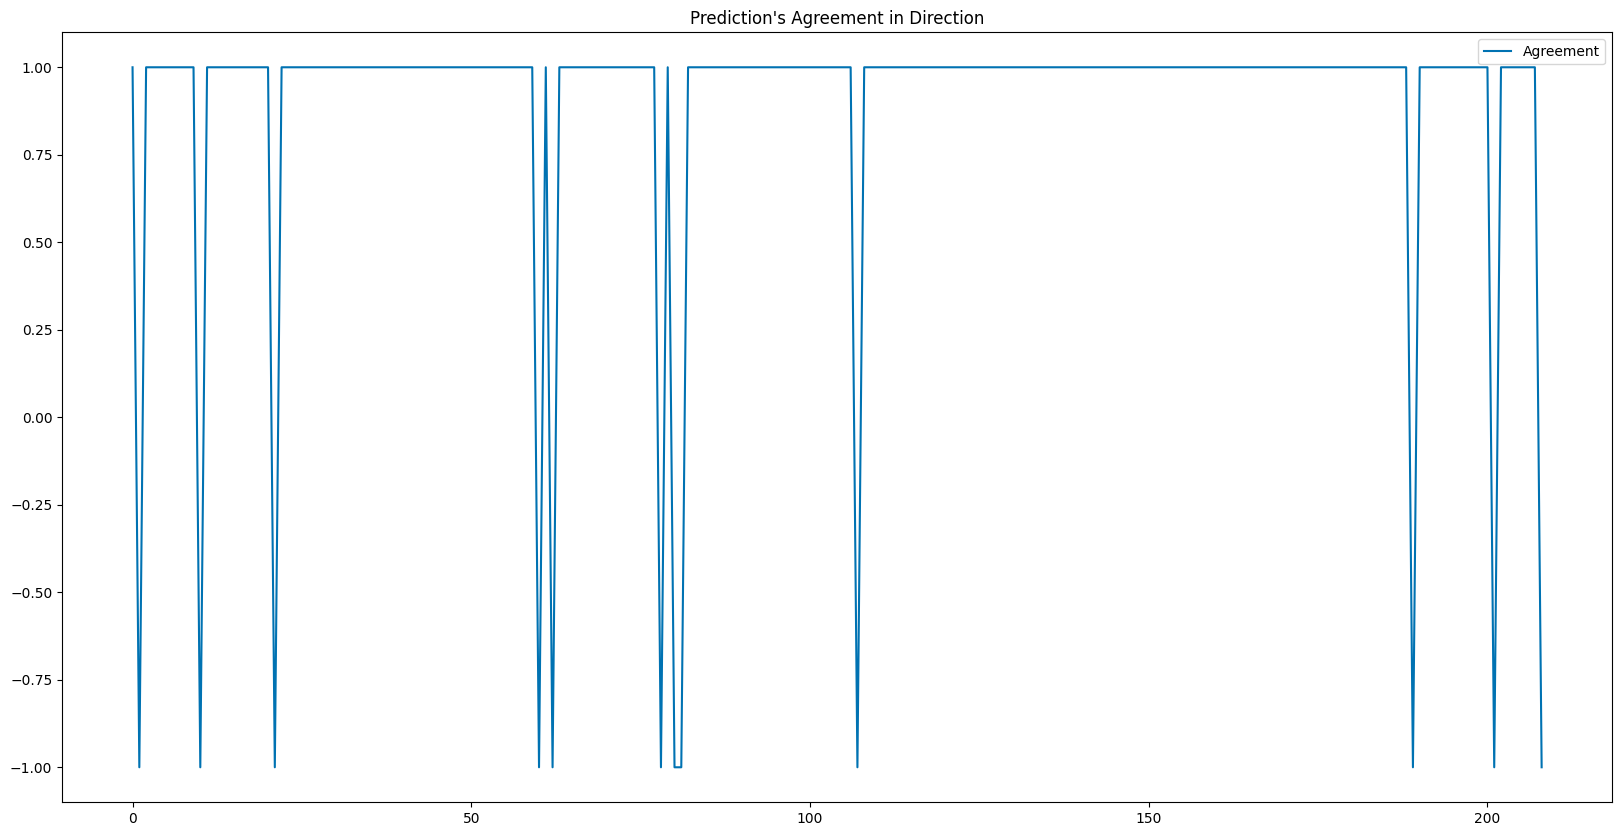

In [950]:
a_dir_df = pd.DataFrame(data=s_prediction, columns=["S Dir"])
a_dir_df.insert(1, "N Dir", n_prediction)

a_dir_df["Agreement"] = 0
a_dir_df.loc[(a_dir_df["S Dir"] * a_dir_df["N Dir"] > 0), "Agreement"] = 1
a_dir_df.loc[(a_dir_df["S Dir"] * a_dir_df["N Dir"] < 0), "Agreement"] = -1 # opp

a_dir_df.plot(y=["Agreement"], figsize=(20, 10), title="Prediction's Agreement in Direction")

print(a_dir_df["Agreement"].value_counts())